In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import h5py
import os
import seaborn as sns


In [4]:
# Wavefunction generation
from pyscf import lib, gto, scf
from pyscf import gto, mp, mcscf
def He_casci(scf_checkfile, ci_checkfile):
    mol = gto.M(
        atom="He 0. 0. 0.0",
        basis=f"ccecpccpvtz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.ROHF(mol).run()
    mf.chkfile = scf_checkfile
    mf.kernel()
    mc = mcscf.CASCI(mf, 6, 2)
    mc.fcisolver.nroots = 4
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff    
    return mol, mf, mc

In [5]:
scf_checkfile = 'rohf.chk'
ci_checkfile = 'casci.chk'
for fname in [scf_checkfile, ci_checkfile]:
    if os.path.isfile(fname):
        os.remove(fname)
mol, mf, mc = He_casci(scf_checkfile, ci_checkfile)

dict_keys(['mol', '_scf', 'verbose', 'stdout', 'max_memory', 'ncas', 'nelecas', '_ncore', 'fcisolver', 'frozen', 'extrasym', 'e_tot', 'e_cas', 'ci', 'mo_coeff', 'mo_energy', 'mo_occ', 'converged'])


In [6]:
# nstates = 3
# mcs = [copy.copy(mc) for i in range(nstates)]
# for i in range(nstates):
#         mcs[i].ci = mc.ci[i]

In [7]:
# Multi determinant boson new gradient
import importlib, bosonrecipes, bosonslater, bosonwftools
modules = [importlib, bosonrecipes, bosonslater, bosonwftools]
for m in modules:
    importlib.reload(m)

import importlib, slater, pyscftools,recipes, wftools, mc, slater, determinant_tools
modules = [importlib, slater, pyscftools,recipes, wftools, mc, slater, determinant_tools]
for m in modules:
    importlib.reload(m)


# import pyqmc.pyscftools as pyscftools

nconfig = 1000
multi = True
if multi:
    mol, mf, mcc = pyscftools.recover_pyscf(scf_checkfile, ci_checkfile = ci_checkfile)
    target_root = 0
    if not hasattr(mcc.ci, "shape") or len(mcc.ci.shape) == 3:
        mcc.ci = mcc.ci[target_root]
else:
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    mcc = None

wf = slater.Slater(mol, mf, mc=mcc)

In [8]:
# wf._det_map

In [9]:
nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
# wf.parameters['det_coeff'] = np.ones(len(wf.parameters['det_coeff']))
signb, phib = wf.recompute(configs)
configs.configs[0]

array([[-0.66208443,  2.78633504,  1.15408253],
       [ 0.84019143,  0.08145467,  0.01335819]])

In [10]:
# wf.parameters["det_coeff"]

In [11]:
wf.recompute(configs)
updets = wf._dets[0][:, :, wf._det_map[0]]
dndets = wf._dets[1][:, :, wf._det_map[1]]
updets.shape

(2, 1000, 36)

In [12]:
# import pyqmc.gpu as gpu
# upref = gpu.cp.amax(updets[1]).real
# dnref = gpu.cp.amax(dndets[1]).real
# phases = updets[0] * dndets[0]
# logvals = updets[1] - upref + dndets[1] - dnref
# phases = updets[0] * dndets[0]
# wf_vals = phases * gpu.cp.exp(logvals)
    
# wf_val = gpu.cp.einsum("id->i", phases * gpu.cp.exp(logvals)) # no def coeff
# wf_sign = np.nan_to_num(wf_val / gpu.cp.abs(wf_val))
# wf_logval = np.nan_to_num(gpu.cp.log(gpu.cp.abs(wf_val)) + upref + dnref)

In [13]:
# wf_val.shape

In [14]:
# ref = np.max(wf_vals, axis=0)
# denominator = np.sum(np.exp(2 * (wf_vals - ref)), axis=0)
# normalized_values = phases * np.exp(wf_vals - ref)

In [15]:
# np.einsum(  # shape (wf, wf)
#         "ik,jk->ij", normalized_values.conj(), normalized_values / denominator
#     ) / len(ref)

In [16]:
# weight = np.exp(-2 * (wf_vals[:, np.newaxis] - wf_vals))
# weight = 1.0 / np.sum(weight, axis=1)

In [17]:
# weight.shape

In [18]:
# psi_i = np.einsum('ni, ni, ni, ni->ni', updets[0], np.exp(updets[1]), dndets[0], np.exp(dndets[1]))
# rho = np.sum(psi_i**2, axis=1)
# rho.shape

In [29]:
nup = np.einsum('ni, ni, nj, nj->nij', updets[0], np.exp(updets[1]), updets[0], np.exp(updets[1]))
ndn = np.einsum('ni, ni, nj, nj->nij', dndets[0], np.exp(dndets[1]), dndets[0], np.exp(dndets[1]))

psi_i = np.einsum('ni, ni, ni, ni->ni', updets[0], np.exp(updets[1]), dndets[0], np.exp(dndets[1]))
psi_ij = np.sqrt(np.einsum('ni, ni, nj, nj ->nij', psi_i, psi_i, psi_i, psi_i))
# psi_i_sum  = np.sum(psi_i**2, axis=0)

# # rho = np.sum(psi_i**2, axis=1)

ovlp_ij  = nup*ndn
# nom = np.einsum('nij, n->ij', ovlp_ij, np.sqrt(rho))

# # d1 = np.einsum('ni, ni, n->i', psi_i, psi_i, rho)
# # d  = np.sqrt(np.einsum('i, j->ij', d1, d1))

# # ovlp = nom/d
# import seaborn as sns
# # sns.heatmap(ovlp,  linewidths=.5)
# sns.heatmap(nom,  linewidths=.5)


In [20]:
psi_i.shape

(1000, 36)

In [21]:
psi_ij.shape

(1000, 36, 36)

In [22]:
ovlp_ij.shape

(1000, 36, 36)

In [23]:
# psi_i_sum.shape

In [24]:
ovlp_ij.shape

(1000, 36, 36)

<Axes: >

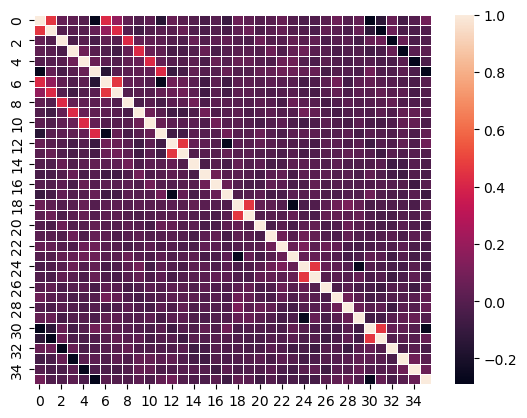

In [25]:
d = np.mean(ovlp_ij/psi_ij, axis=0)
sns.heatmap(d,  linewidths=.5)

0.044

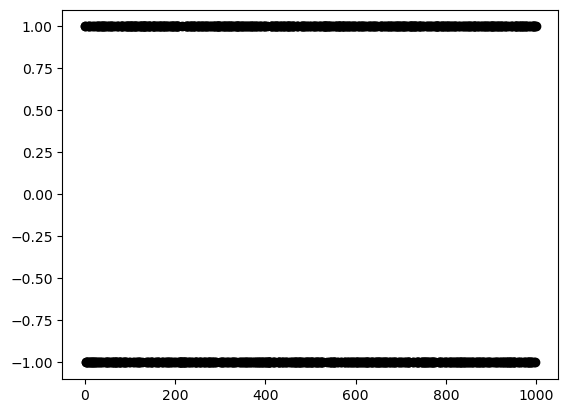

In [28]:
i = 0
j = 2
y = ovlp_ij[:, i, j]/psi_ij[:,i,j]
plt.plot(y, 'ok')
np.mean(y)

In [110]:
# Read from parallel calculation

In [74]:
import h5py 
f = h5py.File("abvmc.hdf5", "r")

In [75]:
f.keys()

<KeysViewHDF5 ['acceptance', 'block', 'configs', 'energycorr', 'energyee', 'energyei', 'energygrad2', 'energyii', 'energyka', 'energykb', 'energyke', 'energytotal', 'energyvh', 'energyvxc', 'excitationsdelta', 'excitationsovlp_ij', 'excitationsovlp_nom', 'excitationspsi_ij', 'excitationswf_val', 'nconfig']>

(50, 36, 36)


<Axes: >

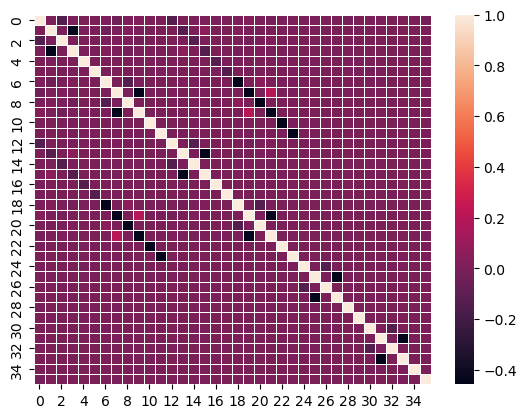

In [155]:
import seaborn as sns

nom=f['excitationsovlp_nom']
# p_ovlp_ij=f['excitationsovlp_ij']
# p_psi_ij=f['excitationspsi_ij']
print(nom.shape)
nom_avg = np.average(nom, axis=0)
sns.heatmap(nom_avg,  linewidths=.5)

<Axes: >

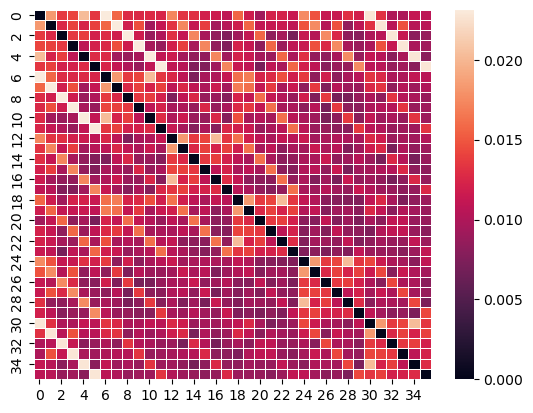

In [156]:
nom_std = np.std(nom, axis=0)
sns.heatmap(nom_std,  linewidths=.5)

<Axes: >

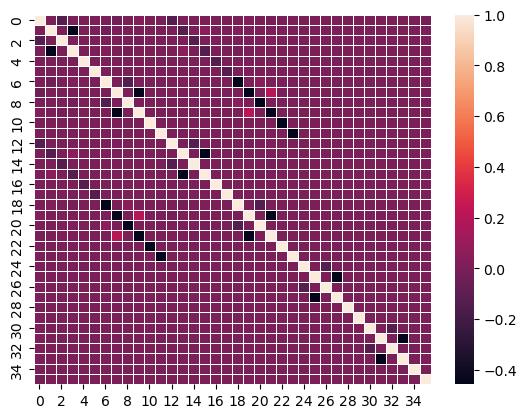

In [157]:
import copy
nom_new = copy.deepcopy(nom_avg)
nom_new[nom_std>np.abs(nom_avg)] = 0
sns.heatmap(nom_new,  linewidths=.5)

1.0

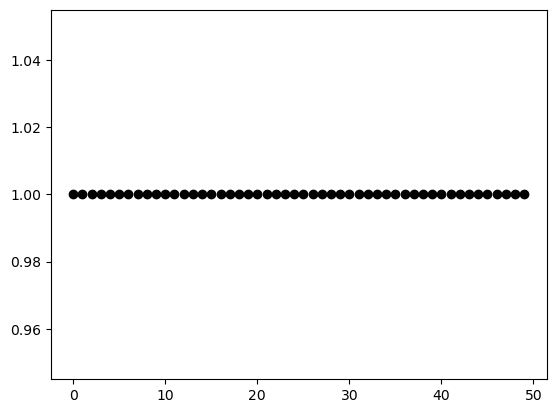

In [158]:
i = 0
j = 0
y = p_ovlp_ij[:, i, j]/p_psi_ij[:,i,j]
plt.plot(y, 'ok')
np.mean(y)

In [159]:
# d1=f['excitationsovlp_d1']
# print(d1.shape)

# d1_avg = np.average(d1, axis=0)
# # denom = np.einsum('i, j->ij', d1_avg, d1_avg)
# # denom_avg = np.sqrt(denom)
# # res = nom_avg/denom_avg
# sns.heatmap(d1_avg,  linewidths=.5)
